# Project 2

## Step 0

**Mini research question (v0):**  
How do average housing prices differ across districts in Shanghai, and how does this pattern relate to district-level population?

**Datasets:**
- 2024 Shanghai second-hand housing listings (Anjuke): used to compute **average unit price (RMB/m²)** by district.  
- 2024 Shanghai resident population by district (compiled from Shanghai Statistical Yearbook 2024).

**What we’ll do:**
- Use pandas to clean each dataset and aggregate both to the **district** level.  
- Merge the two datasets so each district has both **average price** and **population**.  
- Use a Shanghai district GeoJSON to build a **choropleth map** .  
- Add one additional visualization (e.g., bar chart of population by district) and state the main takeaway.

# Step 1
Import required libraries

In [14]:
import pandas as pd
import json
import plotly.express as px

In [15]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype"

# Step 2
Read raw housing data (Chinese columns)

In [16]:
housing_raw = pd.read_csv("dataset.csv", encoding="utf-8")

print(housing_raw.columns)
housing_raw.head()

Index(['居室数', '厅堂数', '卫生间数', '总面积', '建造年份', '居民楼总层数', '小区户数', '小区绿化率', '物业费用',
       '小区均价', '装修', '楼层分布', '物业类型', '产权性质', '产权年限', '房本年限', '区', '街道', '小区',
       '南', '南北', '近地铁', '车位充足', '户型方正', '多人关注', '有电梯', '价格'],
      dtype='object')


,居室数,厅堂数,卫生间数,总面积,建造年份,居民楼总层数,小区户数,小区绿化率,物业费用,小区均价,...,街道,小区,南,南北,近地铁,车位充足,户型方正,多人关注,有电梯,价格
0,2,1,1,17,2018.0,11.0,50.0,30.0,0.40,28445,...,虹桥,虹中路2弄小区,False,True,True,True,False,False,False,50
1,3,2,1,97,2014.0,22.0,2336.0,45.0,3.00,103551,...,御桥,万科海上传奇(一二期),True,False,True,False,False,False,False,910
2,3,1,1,93,2007.0,11.0,1731.0,30.0,1.25,34202,...,浦江,虹浦新城(南区),False,True,True,False,False,False,True,355
3,2,2,1,90,2013.0,11.0,971.0,35.0,1.20,35224,...,航头,沉香苑一街坊,False,True,True,False,True,False,False,286
4,5,3,3,300,2010.0,2.0,68.0,43.0,5.50,188277,...,虹桥,虹梅别墅,True,False,True,True,False,False,False,4100


# Step 3
Rename Chinese columns to English

In [17]:
rename_dict = {
    "居室数": "bedrooms",
    "厅堂数": "living_rooms",
    "卫生间数": "bathrooms",
    "总面积": "area_sqm",
    "建造年份": "year_built",
    "居民楼总层数": "building_floors",
    "小区户数": "community_num_households",
    "小区绿化率": "community_green_ratio",
    "物业费用": "property_fee_rmb_per_sqm",
    "小区均价": "community_avg_price_rmb_per_sqm",
    "装修": "decoration",
    "楼层分布": "floor_position",
    "物业类型": "property_type",
    "产权性质": "ownership_type",
    "产权年限": "property_rights_years",
    "房本年限": "years_since_purchase",
    "区": "district_cn",
    "街道": "subdistrict_cn",
    "小区": "community_cn",
    "南": "facing_south",
    "南北": "facing_south_north",
    "近地铁": "near_metro",
    "车位充足": "ample_parking",
    "户型方正": "regular_layout",
    "多人关注": "many_followers",
    "有电梯": "has_elevator",
    "价格": "total_price_10k_rmb" 
}

housing = housing_raw.rename(columns=rename_dict)

print(housing.columns)
housing.head()

Index(['bedrooms', 'living_rooms', 'bathrooms', 'area_sqm', 'year_built',
       'building_floors', 'community_num_households', 'community_green_ratio',
       'property_fee_rmb_per_sqm', 'community_avg_price_rmb_per_sqm',
       'decoration', 'floor_position', 'property_type', 'ownership_type',
       'property_rights_years', 'years_since_purchase', 'district_cn',
       'subdistrict_cn', 'community_cn', 'facing_south', 'facing_south_north',
       'near_metro', 'ample_parking', 'regular_layout', 'many_followers',
       'has_elevator', 'total_price_10k_rmb'],
      dtype='object')


,bedrooms,living_rooms,bathrooms,area_sqm,year_built,building_floors,community_num_households,community_green_ratio,property_fee_rmb_per_sqm,community_avg_price_rmb_per_sqm,...,subdistrict_cn,community_cn,facing_south,facing_south_north,near_metro,ample_parking,regular_layout,many_followers,has_elevator,total_price_10k_rmb
0,2,1,1,17,2018.0,11.0,50.0,30.0,0.40,28445,...,虹桥,虹中路2弄小区,False,True,True,True,False,False,False,50
1,3,2,1,97,2014.0,22.0,2336.0,45.0,3.00,103551,...,御桥,万科海上传奇(一二期),True,False,True,False,False,False,False,910
2,3,1,1,93,2007.0,11.0,1731.0,30.0,1.25,34202,...,浦江,虹浦新城(南区),False,True,True,False,False,False,True,355
3,2,2,1,90,2013.0,11.0,971.0,35.0,1.20,35224,...,航头,沉香苑一街坊,False,True,True,False,True,False,False,286
4,5,3,3,300,2010.0,2.0,68.0,43.0,5.50,188277,...,虹桥,虹梅别墅,True,False,True,True,False,False,False,4100


# Step 4
Create an English district column so that it matches the population dataset

In [18]:
district_map = {
    "黄浦": "Huangpu",
    "徐汇": "Xuhui",
    "长宁": "Changning",
    "静安": "Jing'an",
    "普陀": "Putuo",
    "虹口": "Hongkou",
    "杨浦": "Yangpu",
    "闵行": "Minhang",
    "宝山": "Baoshan",
    "嘉定": "Jiading",
    "浦东": "Pudong New Area", 
    "金山": "Jinshan",
    "松江": "Songjiang",
    "青浦": "Qingpu",
    "奉贤": "Fengxian",
    "崇明": "Chongming",
    "上海周边": "Shanghai surroundings" 
}

housing["district"] = housing["district_cn"].map(district_map)

# Keep only listings that are inside the 16 districts (drop "Shanghai surroundings")
housing = housing[housing["district"].notna()]

housing[["district", "community_avg_price_rmb_per_sqm", "total_price_10k_rmb"]].head()


,district,community_avg_price_rmb_per_sqm,total_price_10k_rmb
0,Minhang,28445,50
1,Pudong New Area,103551,910
2,Minhang,34202,355
3,Pudong New Area,35224,286
4,Minhang,188277,4100


# Step 5
Compute average unit price per district

In [19]:
price_by_dist = (
    housing
    .groupby("district", as_index=False)["community_avg_price_rmb_per_sqm"]
    .mean()
)

price_by_dist.rename(
    columns={"community_avg_price_rmb_per_sqm": "avg_unit_price_rmb_per_sqm_2024"},
    inplace=True
)

price_by_dist


,district,avg_unit_price_rmb_per_sqm_2024
0,Baoshan,44170.883324
1,Changning,79181.859089
2,Chongming,18641.060556
3,Fengxian,25851.761221
4,Hongkou,77053.640360
5,Huangpu,112514.436005
6,Jiading,38717.595484
7,Jing'an,83284.811588
8,Jinshan,17202.110835
9,Minhang,57078.919621


# Step 6
 Read population data

In [20]:
pop = pd.read_csv("shanghai_population_2024.csv")

pop.head()
print(pop.columns)


Index(['District_CN', 'District_EN', 'Population_10k', 'Population_persons',
       'Note'],
      dtype='object')


# Step 7
Keep only English district name and population

In [21]:
pop_clean = (
    pop[["District_EN", "Population_persons"]]
    .rename(columns={
        "District_EN": "district",
        "Population_persons": "population_persons"
    })
)

pop_clean


,district,population_persons
0,Huangpu,503400
1,Xuhui,1109800
2,Changning,685300
3,Jing'an,929300
4,Putuo,1248700
5,Hongkou,714800
6,Yangpu,1199700
7,Pudong New Area,5785800
8,Minhang,2725000
9,Baoshan,2263900


# Step 8
Merge housing (average price) and population

In [22]:
df = price_by_dist.merge(pop_clean, on="district", how="inner")

df


,district,avg_unit_price_rmb_per_sqm_2024,population_persons
0,Baoshan,44170.883324,2263900
1,Changning,79181.859089,685300
2,Chongming,18641.060556,592200
3,Fengxian,25851.761221,1139500
4,Hongkou,77053.640360,714800
5,Huangpu,112514.436005,503400
6,Jiading,38717.595484,1890400
7,Jing'an,83284.811588,929300
8,Jinshan,17202.110835,812300
9,Minhang,57078.919621,2725000


# Step 9
Read Shanghai district GeoJSON

In [23]:
with open("Shanghai_310000_full.json", "r", encoding="utf-8") as f:
    sh_geo = json.load(f)

# Check one feature to see the properties
sh_geo["features"][0]["properties"]


{'adcode': 310101,
 'name': '黄浦区',
 'center': [121.490317, 31.222771],
 'centroid': [121.483572, 31.215946],
 'childrenNum': 0,
 'level': 'district',
 'parent': {'adcode': 310000},
 'subFeatureIndex': 0,
 'acroutes': [100000, 310000]}

# Step 10
Add Chinese district names for mapping

In [24]:
# Merge the Chinese names from the population table into df
df = df.merge(
    pop[["District_EN", "District_CN"]],
    left_on="district",
    right_on="District_EN",
    how="left"
)

# Drop duplicate column to keep the dataframe clean
df = df.drop(columns=["District_EN"])

df.head()


,district,avg_unit_price_rmb_per_sqm_2024,population_persons,District_CN
0,Baoshan,44170.883324,2263900,宝山区
1,Changning,79181.859089,685300,长宁区
2,Chongming,18641.060556,592200,崇明区
3,Fengxian,25851.761221,1139500,奉贤区
4,Hongkou,77053.640360,714800,虹口区


# Step 11
Draw the choropleth map of housing price

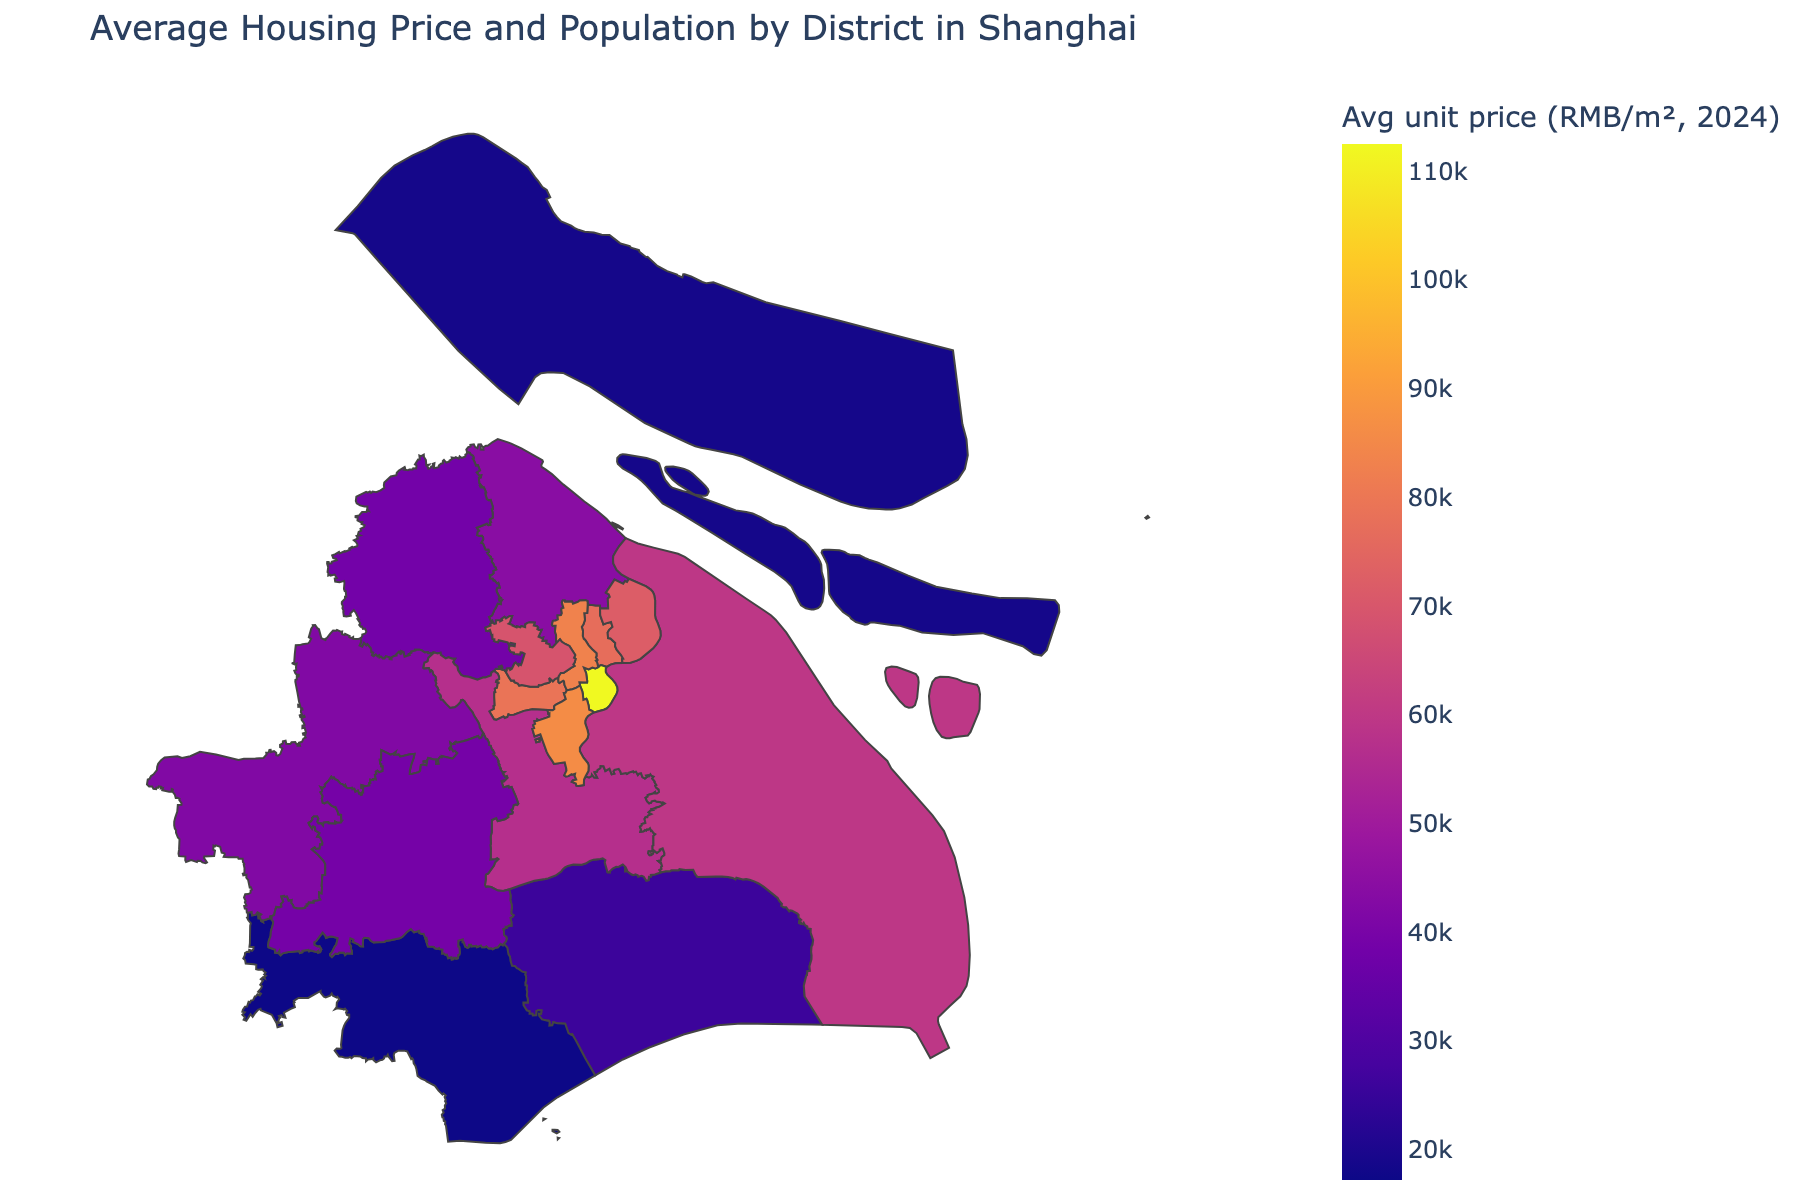

In [25]:
# In the GeoJSON file, district names are stored under properties.name (Chinese)
feature_key = "properties.name"

fig = px.choropleth(
    df,
    geojson=sh_geo,
    locations="District_CN",          # Chinese district names
    featureidkey=feature_key,         # Match to 'properties.name' in GeoJSON
    color="avg_unit_price_rmb_per_sqm_2024",
    projection="mercator",
    hover_name="district",            # English district name shown on hover
    hover_data={
        "avg_unit_price_rmb_per_sqm_2024": "':.0f'",
        "population_persons": "':,.0f'",
        "District_CN": False,         # Hide Chinese names in tooltip
    },
    labels={
        "avg_unit_price_rmb_per_sqm_2024": "Avg unit price (RMB/m², 2024)",
        "population_persons": "Population",
    },
    title="Average Housing Price and Population by District in Shanghai"
)

# Center and clean up the layout
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0, "t":40, "l":0, "b":0})



import plotly.io as pio
from IPython.display import Image, display

pio.write_image(fig, "shanghai_map.png", width=900, height=600, scale=2)

display(Image("shanghai_map.png"))


# Step 12
Bar chart of population by district

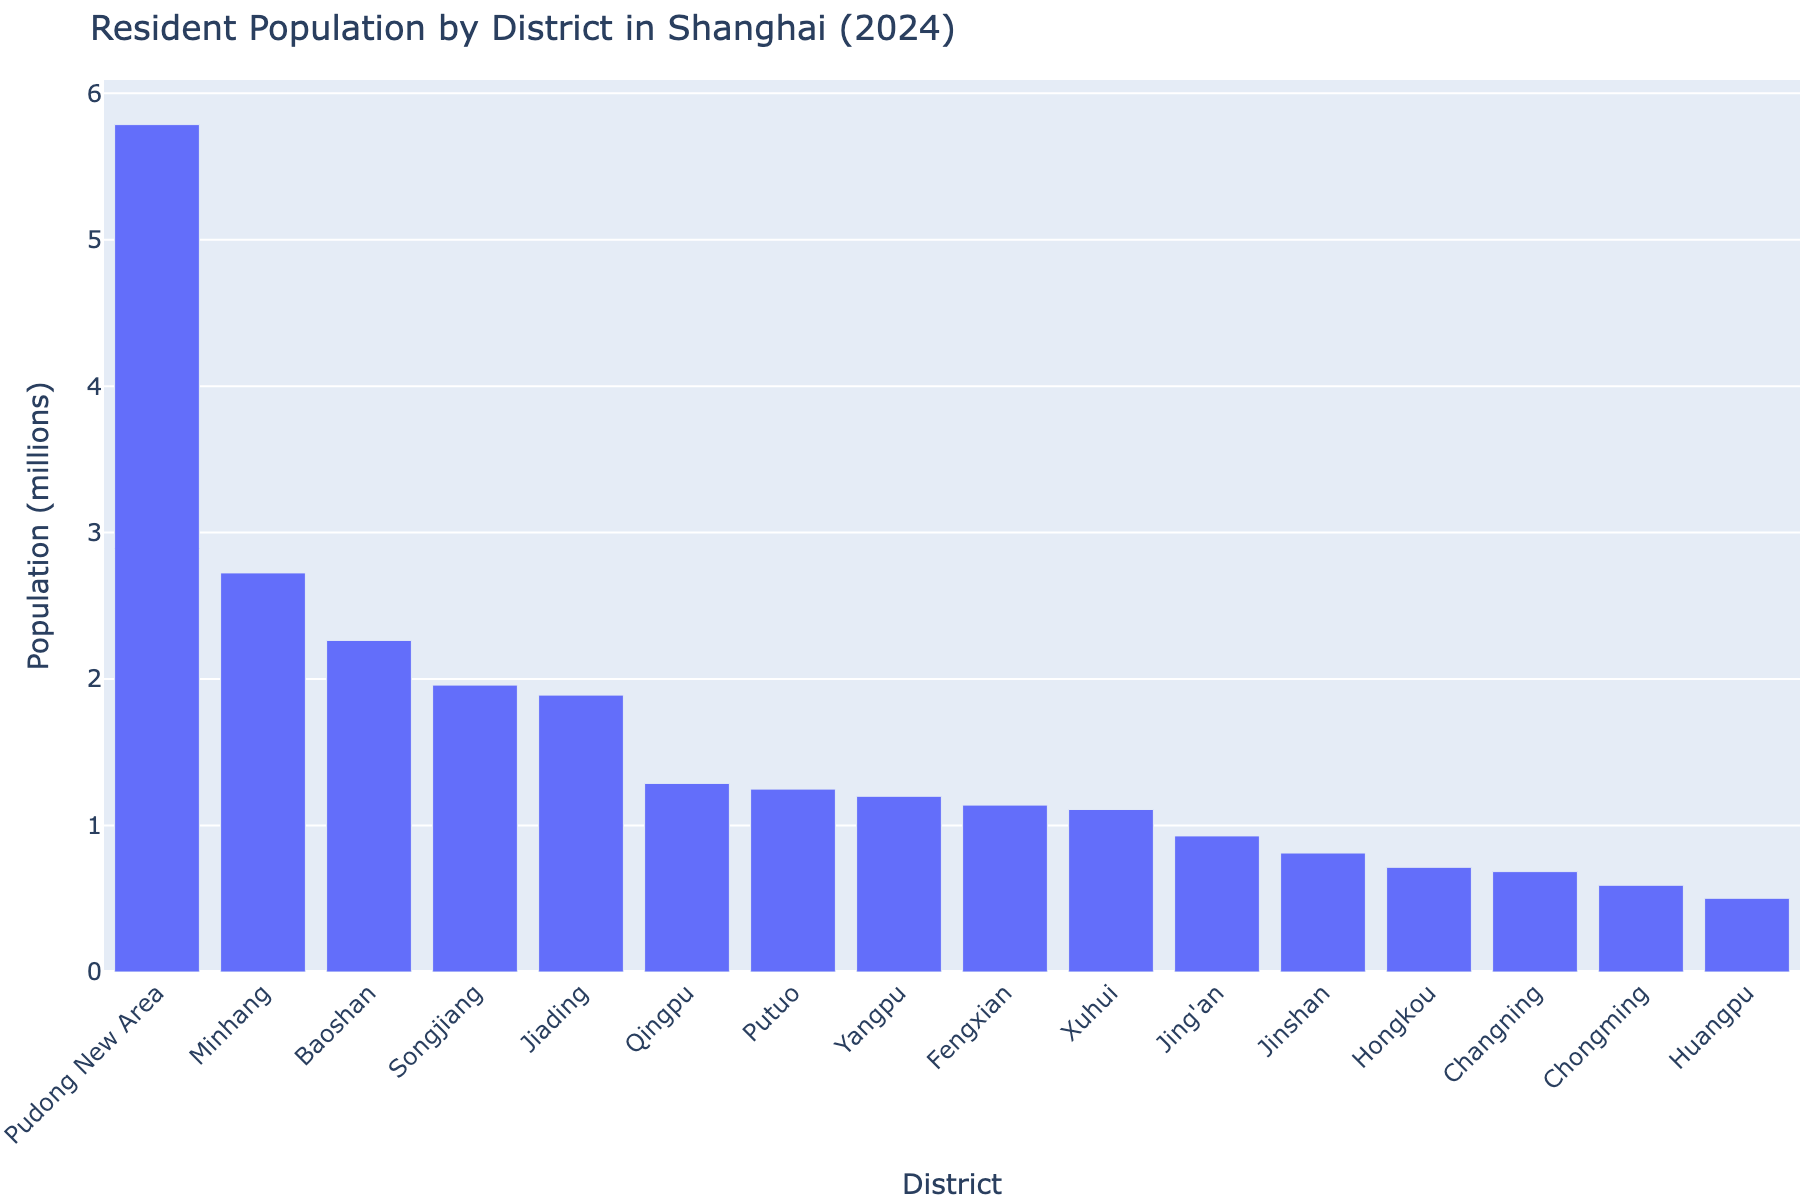

In [26]:
# Keep one row per district and sort by population (descending)
pop_bar = (
    df[["district", "population_persons"]]
    .drop_duplicates()
    .sort_values("population_persons", ascending=False)
    .copy()
)

# convert to millions to make the axis easier to read
pop_bar["population_millions"] = pop_bar["population_persons"] / 1_000_000

fig = px.bar(
    pop_bar,
    x="district",                
    y="population_millions",    
    labels={
        "district": "District",
        "population_millions": "Population (millions)"
    },
    title="Resident Population by District in Shanghai (2024)"
)

# Make x-axis labels easier to read
fig.update_layout(
    xaxis_tickangle=-45,
    margin={"r":0, "t":40, "l":0, "b":80}
)

pio.write_image(fig, "shanghai_pop_bar.png", width=900, height=600, scale=2)

display(Image("shanghai_pop_bar.png"))

